In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
engine

Engine(sqlite:///Resources/hawaii.sqlite)

In [23]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


/var/folders/2g/q9rlpx794g7c0msfzn614x200000gn/T/ipykernel_15141/2639776237.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [24]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [25]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Latest Date: {most_recent_date}")

Latest Date: 2017-08-23


In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_year_ago = func.date(most_recent_date, '-1 year')
# Perform a query to retrieve the data and precipitation scores

precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

#precipitation_data

In [29]:

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])
df



,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


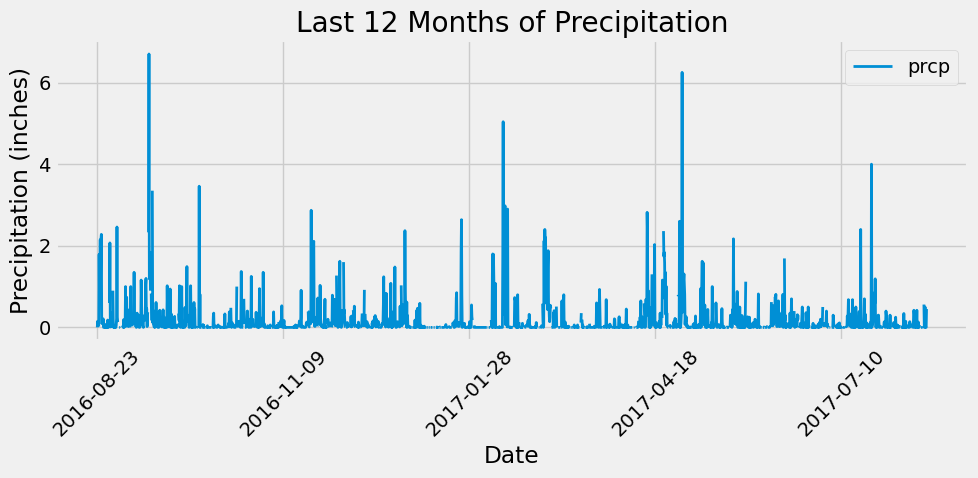

In [30]:
# Sort the dataframe by date

df = df.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data

df.set_index('date', inplace=True)
df.plot(figsize=(10, 5), linewidth=2)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# Use Pandas to calculate the summary statistics for the precipitation data


summary_statistics = df['prcp'].describe()
print(summary_statistics)



count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [33]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Convert query results to a Pandas DataFrame
df_active_stations = pd.DataFrame(active_stations, columns=['station', 'count'])

# Print the DataFrame
print(df_active_stations)


       station  count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511


In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = active_stations[0][0]
print(f"Most Active Station: {most_active_station}")

temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

# Extract the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp:.2f}")


Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


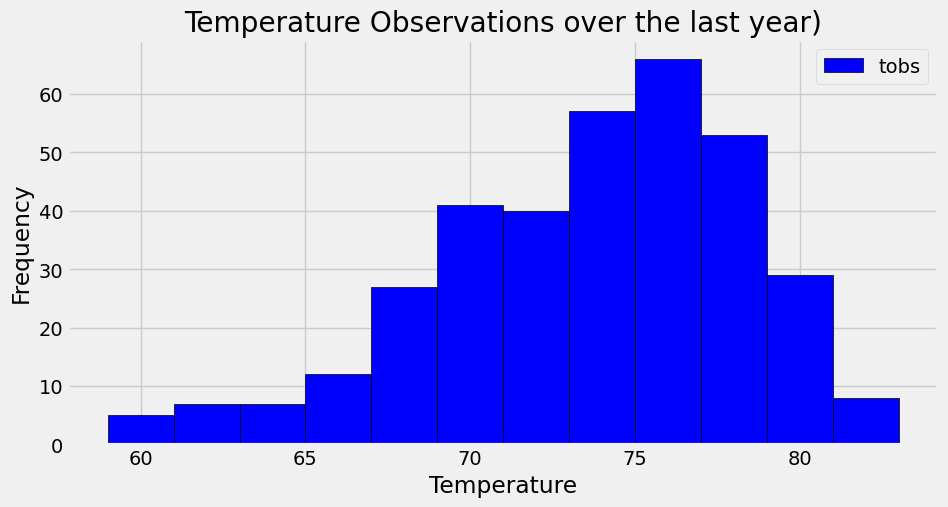

In [35]:
# Using the most active station id

# Retrieve the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

df_temperature = pd.DataFrame(temperature_data, columns=['date', 'tobs'])

# Plot the results as a histogram
plt.figure(figsize=(10, 5))
plt.hist(df_temperature['tobs'], bins=12, label='tobs', color='blue', edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations over the last year)')
plt.legend()
plt.show()


# Close Session

In [36]:
# Close Session
session.close()